In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [2]:
# Clearing the environment

try:
    del data_dir, file_paths, labels, class_names, data_df, label_map, inverse_label_map, train_df, test_df, processor, model, train_dataset, test_dataset
except NameError:
    print("Some are non-existent!")

!rm -rf /kaggle/working/*
%reset -f


import gc

def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory

reset_memory()

Some are non-existent!
Memory has been reset


In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/'

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Valid image extensions
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Walk through all subfolders and files
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(valid_extensions):
            file_paths.append(os.path.join(subdir, file))
            labels.append(os.path.basename(subdir))

# Create a DataFrame
data_df = pd.DataFrame({'file_path': file_paths, 'label': labels})
data_df = data_df.sort_values(by='label', ascending=True)

# Display the DataFrame
print(data_df.head())
print(data_df.label.value_counts())

                                              file_path      label
0     /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
3336  /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
3335  /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
3334  /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
3333  /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
label
colon_aca    5000
colon_n      5000
Name: count, dtype: int64


In [4]:
#convert labels to integers
label_map = {label: idx for idx, label in enumerate(data_df['label'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
data_df['label'] = data_df['label'].map(label_map)
print(data_df.head())
print(data_df.tail())

                                              file_path  label
0     /kaggle/input/lung-and-colon-cancer-histopatho...      0
3336  /kaggle/input/lung-and-colon-cancer-histopatho...      0
3335  /kaggle/input/lung-and-colon-cancer-histopatho...      0
3334  /kaggle/input/lung-and-colon-cancer-histopatho...      0
3333  /kaggle/input/lung-and-colon-cancer-histopatho...      0
                                              file_path  label
6663  /kaggle/input/lung-and-colon-cancer-histopatho...      1
6662  /kaggle/input/lung-and-colon-cancer-histopatho...      1
6661  /kaggle/input/lung-and-colon-cancer-histopatho...      1
6668  /kaggle/input/lung-and-colon-cancer-histopatho...      1
9999  /kaggle/input/lung-and-colon-cancer-histopatho...      1


In [5]:
class ColonCancerDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor
        self.samples = self._prepare_samples()

    def _prepare_samples(self):
        samples = []
        for _, row in self.df.iterrows():
            image_path = row['file_path']
            label = row['label']
            try:
                image = Image.open(image_path).convert('RGB')
            except Exception as e:
                print(f"Error loading {image_path}: {e}")
                continue

            samples.append({'image': image, 'label': label})
        return pd.DataFrame(samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        processed_image = self.samples.iloc[idx]['image']
        processed_label = int(self.samples.iloc[idx]['label'])
    
        inputs = self.processor(images=processed_image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)
    
        return {'pixel_values': pixel_values, 'labels': torch.tensor(processed_label, dtype=torch.long)}

In [7]:
from transformers import Trainer, TrainingArguments, TrainerCallback

class PlottingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Collect metrics during training
        if "loss" in logs:
            self.train_losses.append(logs["loss"])
        if "eval_loss" in logs:
            self.eval_losses.append(logs["eval_loss"])
        if "eval_accuracy" in logs:
            self.eval_accuracies.append(logs["eval_accuracy"])
        if "train_accuracy" in logs:
            self.train_accuracies.append(logs["train_accuracy"])

# Initialize the callback
plotting_callback = PlottingCallback()

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size = 0.2, random_state = 42)

In [9]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoFeatureExtractor, ViTImageProcessor, ViTForImageClassification, BeitImageProcessor, BeitForImageClassification, ViTHybridImageProcessor, ViTHybridForImageClassification

# for vit-base
# processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# for swinv2_tiny
# processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window16-256")
# model = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-tiny-patch4-window16-256")

# for beit-base
# processor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
# model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

# for deit-base
processor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224')

# for vit_hybrid_base_bit
# processor = ViTHybridImageProcessor.from_pretrained('google/vit-hybrid-base-bit-384')
# model = ViTHybridForImageClassification.from_pretrained('google/vit-hybrid-base-bit-384')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [10]:
train_dataset = ColonCancerDataset(train_df, processor)
test_dataset = ColonCancerDataset(test_df, processor)

In [11]:
training_args = TrainingArguments(
    output_dir = './results',
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    learning_rate = 1e-5,
    lr_scheduler_type="linear",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 10,
    weight_decay = 0.01,
    report_to = []
)

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [13]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics,
    callbacks=[plotting_callback],
    tokenizer=processor
)

train_results = trainer.train()

trainer.save_model("./best_model")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

eval_results = trainer.evaluate(test_dataset)
trainer.log_metrics("eval", eval_results)
trainer.save_metrics("eval", eval_results)
print(eval_results)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.125900,0.000314,1.000000,1.000000,1.000000,1.000000
2,0.000000,0.000023,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000016,1.000000,1.000000,1.000000,1.000000
4,0.000000,0.000015,1.000000,1.000000,1.000000,1.000000
5,0.000000,0.000011,1.000000,1.000000,1.000000,1.000000
6,0.000000,0.000012,1.000000,1.000000,1.000000,1.000000
7,0.000000,0.000012,1.000000,1.000000,1.000000,1.000000
8,0.000000,0.000011,1.000000,1.000000,1.000000,1.000000
9,0.000000,0.000010,1.000000,1.000000,1.000000,1.000000
10,0.000000,0.000011,1.000000,1.000000,1.000000,1.000000


***** train metrics *****
  epoch                    =         10.0
  total_flos               = 5825246627GF
  train_loss               =       0.0126
  train_runtime            =   0:40:28.52
  train_samples_per_second =       32.942
  train_steps_per_second   =        2.059


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =        1.0
  eval_f1                 =        1.0
  eval_loss               =     0.0003
  eval_precision          =        1.0
  eval_recall             =        1.0
  eval_runtime            = 0:00:25.16
  eval_samples_per_second =     79.466
  eval_steps_per_second   =      4.967
{'eval_loss': 0.00031429374939762056, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 25.1681, 'eval_samples_per_second': 79.466, 'eval_steps_per_second': 4.967, 'epoch': 10.0}


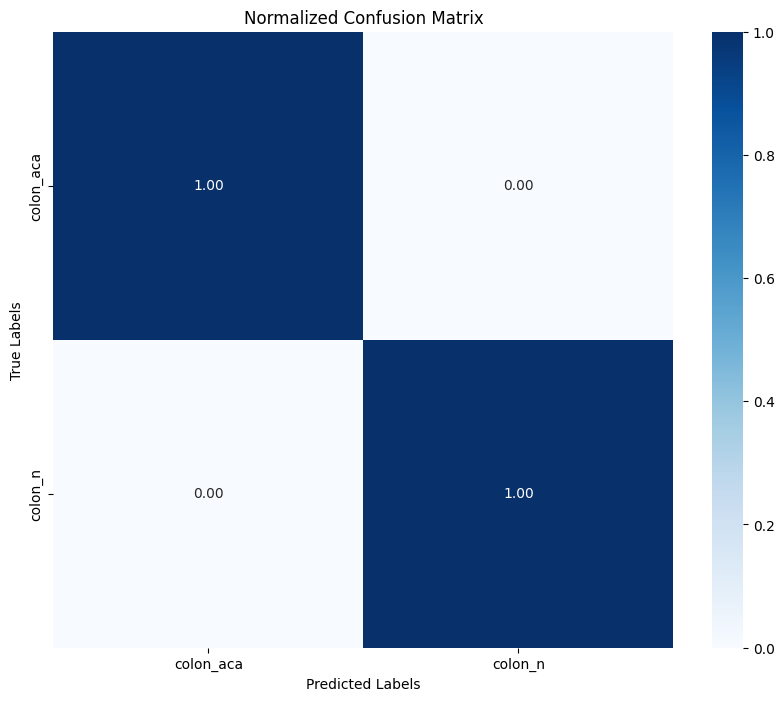

              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00      1012
     colon_n       1.00      1.00      1.00       988

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [14]:
class_names = []

for idx in data_df['label'].unique():
    class_names.append(inverse_label_map[idx])

from sklearn.metrics import confusion_matrix, classification_report

true_labels, predicted_labels = [], []

for idx in range(len(test_dataset)):
    true_labels.append(inverse_label_map[int(test_dataset[idx]['labels'])])
    input_values = test_dataset[idx]['pixel_values'].unsqueeze(0).to('cuda')
    
    with torch.no_grad():
        outputs = model(input_values)
    logits = outputs.logits
    
    predicted_class = logits.argmax(dim = -1).item()
    predicted_labels.append(inverse_label_map[predicted_class])

cm = confusion_matrix(true_labels, predicted_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=class_names))

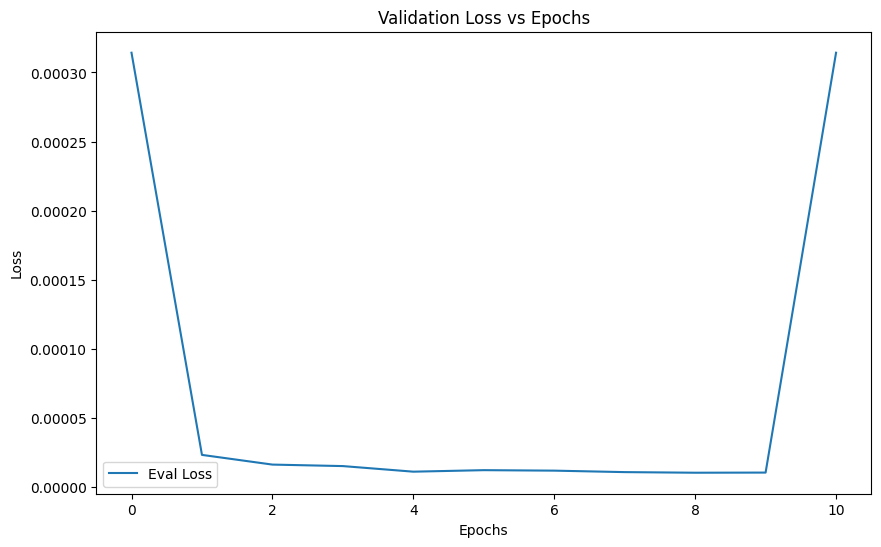

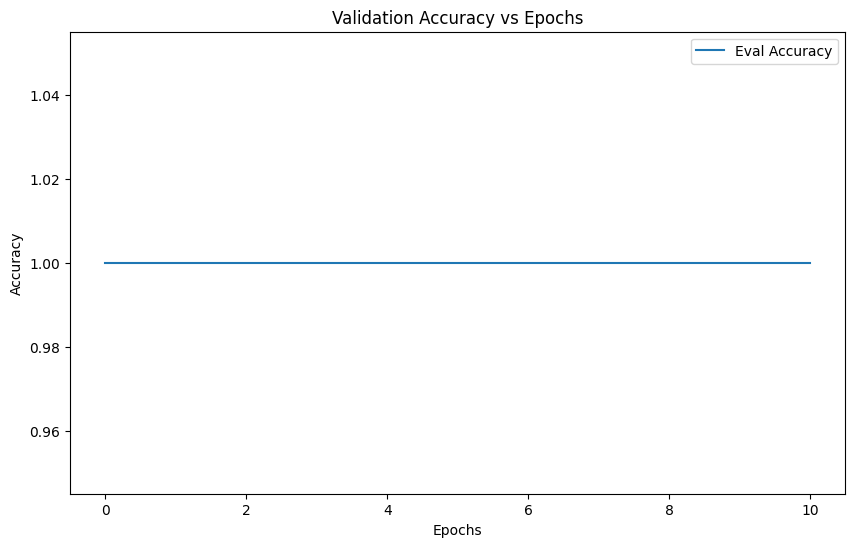

In [15]:
plt.figure(figsize=(10, 6))
# plt.plot(plotting_callback.train_losses, label='Train Loss')
plt.plot(plotting_callback.eval_losses, label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epochs')
plt.legend()
plt.savefig('Loss.png', dpi=1200)
plt.show()

# Plot train & test accuracy
plt.figure(figsize=(10, 6))
# plt.plot(plotting_callback.train_accuracies, label='Train Accuracy')
plt.plot(plotting_callback.eval_accuracies, label='Eval Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.savefig('Acc.png', dpi=1200)
plt.show()